In [1]:
from rdkit import Chem
import pandas as pd 
import matplotlib.pyplot as plt 
import concurrent.futures
import networkx as nx

In [2]:
cid_to_smiles = pd.read_csv("~/data/ChCh/cid_to_smiles.txt", sep="\t", header=None).rename(columns={0:"CID", 1:"SMILES"})

In [3]:
cid_to_smiles.head()

,CID,SMILES
0,155831,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...
1,24762158,CCOP(=O)(CCCCCCCCCC(=O)NCCCCCNC(=O)CCCCC1C2C(C...
2,54692492,CC(=O)C(C(C1=CC=CC=C1)C2=C(C3=CC=CC=C3OC2=O)O)O
3,12968471,CC1(C=CC2=C(O1)C3=C(C=CC=C3OC)NC2=O)C
4,24836820,CCCCCCCC/C(=C\CCCCCCCC(=O)O)/[N+](=O)[O-]


In [4]:
s = cid_to_smiles["SMILES"][0]

In [5]:
m = Chem.MolFromSmiles(s)

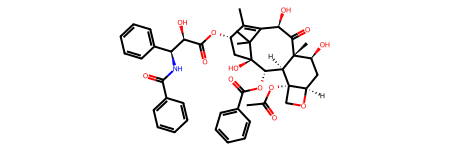

In [6]:
m

In [7]:
from rdkit.DataStructs import TanimotoSimilarity
from rdkit.Chem import AllChem

In [8]:
cid_to_smiles.drop_duplicates(subset=["CID"], inplace=True)
cid_to_smiles.dropna(inplace=True)

In [9]:
cid_to_smiles.drop(5392,inplace=True) # hay error con este siempre para generar el fingerprint

In [10]:
cids = cid_to_smiles["CID"]
smiles = cid_to_smiles["SMILES"]

In [11]:
mols = [Chem.MolFromSmiles(s) for s in smiles]
pairs = [(i, j) for i in range(len(mols)) for j in range(i + 1, len(mols))]

[11:43:52] WARNING: not removing hydrogen atom without neighbors
[11:43:52] WARNING: not removing hydrogen atom without neighbors


In [12]:
def fp_gen(fp_fun):
    return [fp_fun(mol) for mol in mols]

In [13]:
from rdkit.Chem import MACCSkeys

rdkit_fp = AllChem.GetRDKitFPGenerator().GetFingerprint # path-based
circ_fp = AllChem.GetMorganGenerator(radius=3).GetFingerprint # circular 
maccs_fp = MACCSkeys.GenMACCSKeys # predefined substructures

In [14]:
fps_rdkit = fp_gen(rdkit_fp)
fps_morgan = fp_gen(circ_fp)
fps_maccs = fp_gen(maccs_fp)

In [15]:
import multiprocessing as mp

In [16]:
def tani_rdkit(pair):
    i,j = pair
    return TanimotoSimilarity(fps_rdkit[i], fps_rdkit[j])

def tani_circ(pair):
    i,j = pair
    return TanimotoSimilarity(fps_morgan[i], fps_morgan[j])

def tani_maccs(pair):
    i,j = pair
    return TanimotoSimilarity(fps_maccs[i], fps_maccs[j])

In [17]:
with mp.Pool(mp.cpu_count()-2) as pool:
    results_rdkit = pool.map(tani_rdkit, pairs)

In [18]:
with mp.Pool(mp.cpu_count()-2) as pool:
    results_circ = pool.map(tani_circ, pairs)

In [19]:
with mp.Pool(mp.cpu_count()-2) as pool:
    results_maccs = pool.map(tani_maccs, pairs)

In [20]:
import seaborn as sns
import numpy as np
import heapq

In [21]:
results_rdkit = np.array(results_rdkit)
results_circ = np.array(results_circ)
results_maccs = np.array(results_maccs)


In [22]:
def plot_sampled_dif(n):
    sample = np.random.choice(len(pairs), n)

    rdkit_sim_sample = results_rdkit[sample]
    circ_sim_sample = results_circ[sample]
    maccs_sim_sample = results_maccs[sample]

    sorted_idxs = np.argsort(rdkit_sim_sample)
    
    plt.figure(figsize=(10,6))

    plt.plot(rdkit_sim_sample[sorted_idxs], label="rdkit",color="green")
    plt.plot(circ_sim_sample[sorted_idxs],".", label="circ",color="blue",alpha=0.5)
    plt.plot(maccs_sim_sample[sorted_idxs],".", label="maccs",color="red",alpha=0.5)

    plt.xlabel("pairs sorted by rdkit sim")
    plt.ylabel("tanimoto sim")
    plt.legend()
    plt.show()

    return sample, sorted_idxs

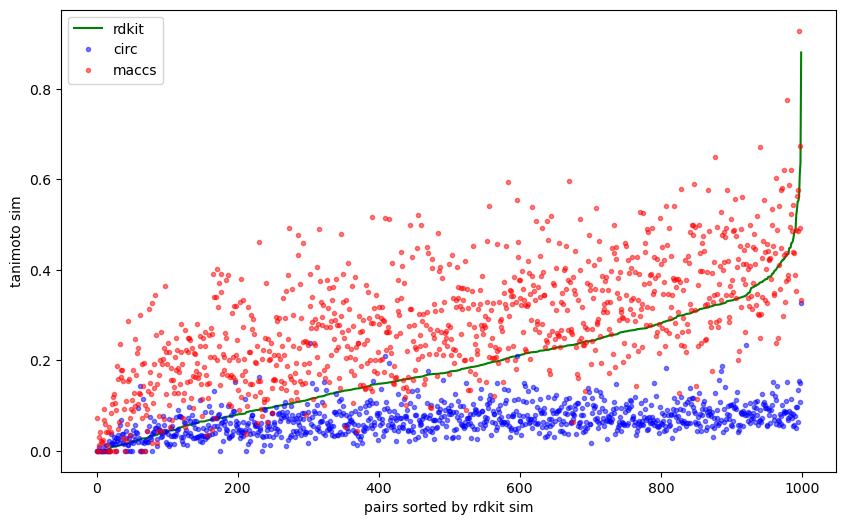

In [23]:
sample_idxs, idxs = plot_sampled_dif(1000)

### agarramos top 20k de c/u y comparamos

In [24]:
def topk(k, sim_results):
    topk = heapq.nlargest(k, enumerate(sim_results), key=lambda x:x[1])
    topk_idxs = [idx for idx,sim in topk]
    topk_sims = [sim for idx,sim in topk]
    return topk_idxs, topk_sims

In [25]:
top_idxs_rdkit, top_sims_rdkit = topk(20000, results_rdkit)
top_idxs_circ, top_sims_circ = topk(20000, results_circ)
top_idxs_maccs, top_sims_maccs = topk(20000, results_maccs)

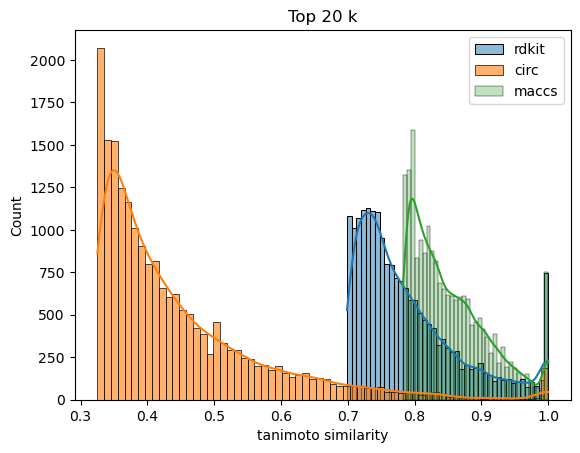

In [26]:
sns.histplot(top_sims_rdkit, kde=True, alpha=0.5, label="rdkit")
sns.histplot(top_sims_circ, kde=True, alpha=0.6, label="circ")
sns.histplot(top_sims_maccs, kde=True, alpha=0.3, label="maccs")
plt.title("Top 20 k")
plt.xlabel("tanimoto similarity")
plt.legend()
plt.show()

In [27]:
top_circ_in_rdkit = results_rdkit[top_idxs_circ]
top_circ_in_maccs = results_maccs[top_idxs_circ]


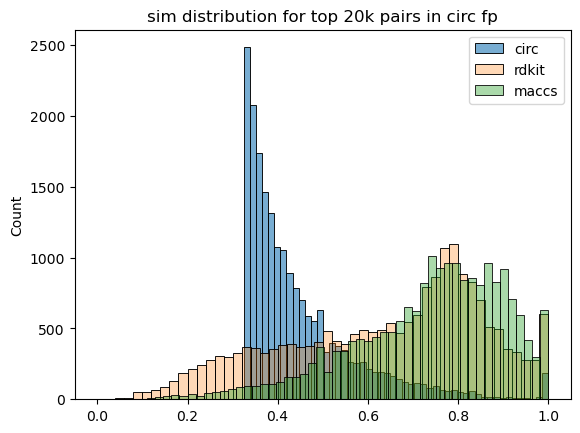

In [30]:
sns.histplot(top_sims_circ, alpha=0.6, bins=50,label="circ")
sns.histplot(top_circ_in_rdkit, alpha=0.3, bins=50,label="rdkit")
sns.histplot(top_circ_in_maccs, alpha=0.4, bins=50, label="maccs")
plt.legend()
plt.title("sim distribution for top 20k pairs in circ fp")
plt.show()

In [ ]:
# veamos la distrbucion pero solo de los pares que comparten


### Network overlap and statistics

In [31]:
cids_vals = cids.values
def make_graph(top_idxs):
    top_pairs_cids = [(cids_vals[pairs[idx][0]], cids_vals[pairs[idx][1]])  for idx in top_idxs]

    edge_df = pd.DataFrame(top_pairs_cids, columns=["src","trgt"])
    G = nx.Graph()
    G.add_nodes_from(cids_vals)
    G.add_edges_from(top_pairs_cids)
    return G, edge_df


In [32]:
circ_fps_net, circ_df = make_graph(top_idxs_circ)
rdkit_fps_net, rdkit_df = make_graph(top_idxs_rdkit)
maccs_fps_net, maccs_df = make_graph(top_idxs_maccs)


In [33]:
def overlap_edges(red_1, red_2):
  return len(set(red_1.edges()) & set(red_2.edges()))/len(red_1.edges())

overlap_df = pd.DataFrame(columns=["circ","rdkit","maccs"], index=["circ","rdkit","maccs"])
for i, red_1 in enumerate([circ_fps_net, rdkit_fps_net, maccs_fps_net]):
  for j, red_2 in enumerate([circ_fps_net, rdkit_fps_net, maccs_fps_net]):
    overlap_df.iloc[i,j] = overlap_edges(red_1, red_2)

overlap_df

,circ,rdkit,maccs
circ,1.0,0.48615,0.4498
rdkit,0.48615,1.0,0.47515
maccs,0.4498,0.47515,1.0


In [36]:
len(ccs

[{12968471},
 {24836820},
 {11724959},
 {1318},
 {6278},
 {91754711},
 {12000797},
 {84677},
 {6331148},
 {57345798},
 {11452311},
 {124418},
 {12318765},
 {73014114},
 {9848499},
 {104751},
 {7243},
 {18728},
 {9001},
 {6437371},
 {53492877},
 {4431},
 {1346},
 {6604926},
 {10667},
 {73023755},
 {135122017},
 {24766011},
 {7845},
 {6438744},
 {7289},
 {57393210},
 {56835165},
 {2723631},
 {4296},
 {49836027},
 {5382},
 {135846071},
 {11560249},
 {25229646},
 {7735},
 {5708351},
 {9840076},
 {115223},
 {6438154},
 {269722},
 {8530},
 {311434},
 {1340},
 {104794},
 {10711997},
 {6681},
 {76190},
 {7840},
 {114924},
 {110733},
 {2723939},
 {1456},
 {72917},
 {1388},
 {39484},
 {11781},
 {11080},
 {95069},
 {9817231},
 {5311479},
 {2762672},
 {146322},
 {17755052},
 {4668801},
 {44215880},
 {246598},
 {73224197},
 {23656215},
 {23284},
 {322968},
 {75575},
 {76739},
 {22463},
 {122265},
 {1474},
 {11534837},
 {119359},
 {102614},
 {12138435},
 {1103147},
 {19707},
 {5310982},
 {5354004},


In [43]:
ccs = sorted(nx.connected_components(circ_fps_net), key=len,reverse=True)
[len(ccs[i])/circ_fps_net.number_of_nodes() for i in range(3)]

[0.4568006843455945, 0.0073567151411462785, 0.005988023952095809]

In [44]:
nx.transitivity(circ_fps_net.subgraph(ccs[0]))

0.6311085916740479

In [56]:
circ_df.to_csv("~/data/ChCh/circ_tani_20k.csv", index=False)
rdkit_df.to_csv("~/data/ChCh/rdkit_tani_20k.csv", index=False)